## import modules for data prep

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import glob
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
'''import nltk
nltk.download('stopwords')'''

"import nltk\nnltk.download('stopwords')"

In [3]:
filenames = list(glob.glob("data/*"))
dataframes = [pd.read_csv(file) for file in filenames]

In [4]:
metadata = pd.concat(dataframes)
metadata.head(10)

,projectname,classification,commenttext
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't been done already"" may // not be strictly true. wrapper.maybeConfigure() won't configure the same // attributes/text more than once, but it may well add the children again, // unless I've missed something."
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what happened // here. Throw the Exception."
3,apache-ant-1.7.0,DEFECT,"// Just a note: StarTeam has a status for NEW which implies // that there is an item on your local machine that is not // in the repository. These are the items that show up as // NOT IN VIEW in the Starteam GUI. // One would think that we would want to perhaps checkin the // NEW items (not in all cases! - Steve Cohen 15 Dec 2001) // Unfortunately, the sdk doesn't really work, and we can't // actually see anything with a status of NEW. That is why // we can just check out everything here without worrying // about losing anything."
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in the generic JAR! // is that buggy on old JOnAS (2.4) ??
5,apache-ant-1.7.0,DEFECT,// todo: is this comment still relevant ?? // FIXME: need to use a SAXSource as the source for the transform // so we can plug in our own entity resolver
6,apache-ant-1.7.0,DEFECT,"// This is turned off temporarily. There appears to be a bug // in SelectorUtils.matchPattern() where it is recursive on // Windows even if no ** is in pattern. //assertEquals(""FFFTFFFFFFFF"", results); // Unix // vs //assertEquals(""FFFTFFFFTFFF"", results); // Windows"
7,apache-ant-1.7.0,DEFECT,// pattern now holds ** while string is not exhausted // this will generate false positives but we can live with that.
8,apache-ant-1.7.0,DEFECT,"// FIXME: Is ""No Namespace is Empty Namespace"" really OK?"
9,apache-ant-1.7.0,DEFECT,// FIXME this is actually not very cpu cycles friendly as we are converting from // dos to java while the underlying Sun implementation will convert // from java to dos time for internal storage...


## Form Labels for SATD

In [5]:
# Is important that text labels are converted into numeric for NN
metadata['label'] = np.where(metadata.classification == 'WITHOUT_CLASSIFICATION', 0, 1)
metadata.head()

,projectname,classification,commenttext,label
0,apache-ant-1.7.0,DEFECT,// FIXME formatters are not thread-safe,1
1,apache-ant-1.7.0,DEFECT,"// XXX: (Jon Skeet) The comment ""if it hasn't been done already"" may // not be strictly true. wrapper.maybeConfigure() won't configure the same // attributes/text more than once, but it may well add the children again, // unless I've missed something.",1
2,apache-ant-1.7.0,DEFECT,"// I hate to admit it, but we don't know what happened // here. Throw the Exception.",1
3,apache-ant-1.7.0,DEFECT,"// Just a note: StarTeam has a status for NEW which implies // that there is an item on your local machine that is not // in the repository. These are the items that show up as // NOT IN VIEW in the Starteam GUI. // One would think that we would want to perhaps checkin the // NEW items (not in all cases! - Steve Cohen 15 Dec 2001) // Unfortunately, the sdk doesn't really work, and we can't // actually see anything with a status of NEW. That is why // we can just check out everything here without worrying // about losing anything.",1
4,apache-ant-1.7.0,DEFECT,// the generated classes must not be added in the generic JAR! // is that buggy on old JOnAS (2.4) ??,1


In [6]:
metadata['label'].value_counts()

0    58204
1     4071
Name: label, dtype: int64

 # Test only on apache ant 

In [7]:
apache_ant_df = metadata[metadata.projectname == 'apache-ant-1.7.0']
apache_ant_df.isnull().sum()

projectname       0
classification    0
commenttext       0
label             0
dtype: int64

## 1] Preprocessing:

#### 1. Remove tags, punctuations, stop words, special characters and return X_clean and y as np arrays
#### 2. Split data in train and test. Remember Xclean and y should reflect metadata used for training 

In [8]:
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')

    return TAG_RE.sub('', text)
    
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    #print(sentence)
    return sentence

def prepare_data(apache_ant_df):
    X_clean = []
    sentences = list(apache_ant_df['commenttext'])

    for sen in sentences:
        X_clean.append(preprocess_text(sen))

    print(X_clean[:3], "\n\n*************************")
    X_clean = np.array(X_clean)
    y = np.array(apache_ant_df.label)

    print("Cleaned corpus shape:", X_clean.shape, y.shape)
    return X_clean, y

def split_data(df):
    X_clean, y = prepare_data(df)
    X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.20, random_state=42)
    print("Train set:",X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, X_val.shape)
    return X_train, X_val, y_train, y_val


In [9]:
X_train, X_val, y_train, y_val = split_data(apache_ant_df)

[' FIXME formatters thread safe', ' XXX Jon Skeet The comment done already may strictly true wrapper maybeConfigure configure attributes text may well add children unless missed something ', ' hate admit know happened Throw Exception '] 

*************************
Cleaned corpus shape: (4098,) (4098,)
Train set: (3278,) (3278,)
Validation set: (820,) (820,)


In [10]:
(X_train)

array([' developer knows ', ' File different see object interface',
       ' promised eliminate consecutive slashes drive letter ', ...,
       ' dont progress unless asked', ' Build command',
       ' error empty set'], dtype='<U838')

## 2] Tokenize the splitted data and convert them intp sequences and add post padding.
- Final output stored as X_train_padded, X-val_padded and y_train and y_val

In [23]:
def prepare_data(X_train, X_val, y_train, y_val):
    
    #Step 2: Use keras to tokenize words and find word.index'length for getting number of unique words i.e vocab size

    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                          lower=True)

    tokenizer.fit_on_texts(X_train)

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    print('VOCAB SIZE: Found %s unique tokens.' % len(word_index))

    # Step 3: Embed the sentences into numbers using text to sequences

    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_valid = tokenizer.texts_to_sequences(X_val)

    # Step 4: next step is to find the number of words in the longest sentence and then to apply 
    #padding to the sentences having shorter lengths than the length of the longest sentence

    from nltk.tokenize import word_tokenize
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(X_train, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    print("Longest sentence length: ",  length_long_sentence)
    
    print("**********************")
    
    #Step 5: Pad zeros at the end using the length of the longest word 
    X_train_padded = pad_sequences(sequences_train,length_long_sentence, padding='post')
    X_val_padded = pad_sequences(sequences_valid,padding='post', maxlen = length_long_sentence)


    print('Shape of X train and X validation tensor:', X_train_padded.shape,X_val_padded.shape)
    print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)
    
    return X_train_padded, X_val_padded, y_train, y_val, vocab_size, word_index, length_long_sentence


In [24]:
X_train_padded, X_val_padded, y_train, y_val, vocab_size, word_index, length_long_sentence= prepare_data(X_train, X_val, y_train, y_val)

VOCAB SIZE: Found 3035 unique tokens.
Longest sentence length:  120
**********************
Shape of X train and X validation tensor: (3278, 120) (820, 120)
Shape of label train and validation tensor: (3278,) (820,)


In [25]:
print(X_train_padded)

[[1205  943    0 ...    0    0    0]
 [   1  108   74 ...    0    0    0]
 [ 944  674  572 ...    0    0    0]
 ...
 [1178  742  312 ...    0    0    0]
 [  20   23    0 ...    0    0    0]
 [  37   70    4 ...    0    0    0]]


In [14]:
def build_embedding_matrix_word2vec(vocab_size, word_index):
    import gensim
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess

    from gensim.models.keyedvectors import KeyedVectors
    path_to_word2vec = 'E:/RIT/GA-TECHNICAL DEBTS/rudimentary-stages/cnn-word2vec/GoogleNews-vectors-negative300.bin'
    word_vectors = KeyedVectors.load_word2vec_format(path_to_word2vec, binary=True)
    
    
    EMBEDDING_DIM= 300
    vocab_size = vocab_size
    
    #Size of embed matrix must be = vocab sizeV * dimension of embeding
    #Step 6: Generate an embedding matrix to get embeddings representaion of words in our corpus
    #Our embedding_matrix now contains pretrained word embeddings for the words in our corpus.
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    for word, i in word_index.items():
        if i>=vocab_size:
            continue
        try:
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
    
    return embedding_matrix


In [15]:
embedding_matrix =  build_embedding_matrix_word2vec(vocab_size, word_index)

In [26]:
def sklearn_weighted_loss(y_train):
    # Calculate the weights for each class so that we can balance the data
    #The minority class will have a higher class weight
    from sklearn.utils import class_weight
    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(y_train),
                                                y_train)
    print("Resultant weight:", weights)
    sklearn_weight = {0: weights[0], 1: weights[1]}
    return sklearn_weight

def weighted_loss(y_train):
    '''Link: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data'''

    neg, pos = np.bincount(y_train)
    total = neg + pos
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    return class_weight
    

## Create Embedding layer on Keras model

In [27]:
embedding_matrix.shape

(3036, 300)

In [28]:
from tensorflow.keras.layers import Embedding

In [29]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [30]:
EMBEDDING_DIM = 300
model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()
# Since my vocab size is 3302 and dimen is 300, Param = 3302*300
# O/P of embedding layer will be 2d matrix with 3302 rows(1 for each word) and 300 cols
# This O/P of embed layer must be flattenned to be used as dense layer for making predictions

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 300)          910800    
_________________________________________________________________
flatten (Flatten)            (None, 36000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 36001     
Total params: 946,801
Trainable params: 36,001
Non-trainable params: 910,800
_________________________________________________________________


In [32]:
custom_class_weights = weighted_loss(y_train)
custom_class_weights
#or use 
sklearn_weights= sklearn_weighted_loss(y_train)

Weight for class 0: 0.52
Weight for class 1: 16.72
Resultant weight: [ 0.51540881 16.7244898 ]


C:\Users\ketak\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [33]:
history = model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_split=0.2, class_weight=custom_class_weights)

Epoch 1/10
82/82 [==============================] - 0s 5ms/step - loss: 0.6177 - acc: 0.4336 - val_loss: 0.7033 - val_acc: 0.5381
Epoch 2/10
82/82 [==============================] - 0s 2ms/step - loss: 0.4505 - acc: 0.7216 - val_loss: 0.5478 - val_acc: 0.8323
Epoch 3/10
82/82 [==============================] - 0s 2ms/step - loss: 0.3716 - acc: 0.8982 - val_loss: 0.4657 - val_acc: 0.8780
Epoch 4/10
82/82 [==============================] - 0s 2ms/step - loss: 0.3130 - acc: 0.9283 - val_loss: 0.3972 - val_acc: 0.9131
Epoch 5/10
82/82 [==============================] - 0s 2ms/step - loss: 0.2725 - acc: 0.9573 - val_loss: 0.3622 - val_acc: 0.9146
Epoch 6/10
82/82 [==============================] - 0s 2ms/step - loss: 0.2393 - acc: 0.9641 - val_loss: 0.3293 - val_acc: 0.9238
Epoch 7/10
82/82 [==============================] - 0s 2ms/step - loss: 0.2144 - acc: 0.9718 - val_loss: 0.3013 - val_acc: 0.9299
Epoch 8/10
82/82 [==============================] - 0s 3ms/step - loss: 0.1934 - acc: 0.97

In [36]:
score  = model.evaluate(X_val_padded, y_val, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.23014990985393524
Test Accuracy: 0.962195098400116


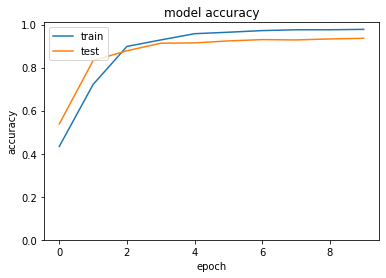

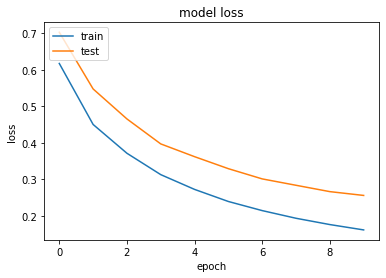

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.ylim([0,1.01])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Try simplest CNN:

In [55]:
'''emb_model = Sequential()
emb_model.add(embedding_layer)
emb_model.add(Conv1D(32,1,activation='relu'))
emb_model.add(GlobalMaxPooling1D())
emb_model.add(Conv1D(32,1,activation='relu'))
emb_model.add(GlobalMaxPooling1D())
emb_model.add(Flatten())
emb_model.add(Dense(10, activation='relu'))
emb_model.add(Dense(1, activation='softmax'))'''


"emb_model = Sequential()\nemb_model.add(embedding_layer)\nemb_model.add(Conv1D(32,1,activation='relu'))\nemb_model.add(GlobalMaxPooling1D())\nemb_model.add(Conv1D(32,1,activation='relu'))\nemb_model.add(GlobalMaxPooling1D())\nemb_model.add(Flatten())\nemb_model.add(Dense(10, activation='relu'))\nemb_model.add(Dense(1, activation='softmax'))"

In [176]:
emb_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
emb_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 300)          910800    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 117, 128)          153728    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 58, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 55, 32)            16416     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)              

In [177]:
emb_history = emb_model.fit(X_train_padded, y_train, batch_size=32, epochs=50, validation_split=0.2, class_weight=sklearn_weights)

Epoch 1/50
82/82 [==============================] - 1s 16ms/step - loss: 7.6198 - acc: 0.0305 - val_loss: 14.8308 - val_acc: 0.0274
Epoch 2/50
82/82 [==============================] - 1s 14ms/step - loss: 7.6198 - acc: 0.0305 - val_loss: 14.8308 - val_acc: 0.0274
Epoch 3/50
82/82 [==============================] - 1s 14ms/step - loss: 7.6198 - acc: 0.0305 - val_loss: 14.8308 - val_acc: 0.0274
Epoch 4/50
82/82 [==============================] - 1s 15ms/step - loss: 7.6198 - acc: 0.0305 - val_loss: 14.8308 - val_acc: 0.0274
Epoch 5/50
82/82 [==============================] - 1s 15ms/step - loss: 7.6198 - acc: 0.0305 - val_loss: 14.8308 - val_acc: 0.0274
Epoch 6/50
82/82 [==============================] - 1s 16ms/step - loss: 7.6198 - acc: 0.0305 - val_loss: 14.8308 - val_acc: 0.0274
Epoch 7/50
82/82 [==============================] - 1s 16ms/step - loss: 7.6198 - acc: 0.0305 - val_loss: 14.8308 - val_acc: 0.0274
Epoch 8/50
82/82 [==============================] - 1s 18ms/step - loss: 7.6

In [178]:
score = emb_model.evaluate(X_val_padded, y_val, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


Test Loss: 14.635550498962402
Test Accuracy: 0.04024390131235123


## Slightly better CNN - try 2D way like the paper

In [41]:
filter_sizes = [3,4,5]
num_filters = 32
drop = 0.5

deep_inputs = Input(shape=(length_long_sentence,))
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)(deep_inputs)
reshape = Reshape((length_long_sentence,EMBEDDING_DIM,1))(embedding)
conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
maxpool_0 = MaxPooling2D((length_long_sentence - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((length_long_sentence - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((length_long_sentence - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
cnn2d_model = Model(deep_inputs, output)

In [42]:
cnn2d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss')]
cnn2d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 120, 300)     910800      input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 120, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 118, 1, 32)   28832       reshape[0][0]                    
______________________________________________________________________________________________

In [48]:
cnn2d_history = cnn2d_model.fit(X_train_padded, y_train, batch_size=64, epochs=50, validation_split=0.2, class_weight=sklearn_weights, callbacks=callbacks)

Epoch 1/50
41/41 [==============================] - 1s 32ms/step - loss: 0.7632 - acc: 0.5297 - val_loss: 0.4245 - val_acc: 0.9726
Epoch 2/50
41/41 [==============================] - 1s 33ms/step - loss: 0.7632 - acc: 0.7407 - val_loss: 0.4245 - val_acc: 0.9726
Epoch 3/50
41/41 [==============================] - 1s 33ms/step - loss: 0.7632 - acc: 0.8345 - val_loss: 0.4245 - val_acc: 0.9726
Epoch 4/50
41/41 [==============================] - 2s 38ms/step - loss: 0.7632 - acc: 0.9695 - val_loss: 0.4245 - val_acc: 0.9726


In [49]:
score = cnn2d_model.evaluate(X_val_padded, y_val, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


Test Loss: 0.4333600401878357
Test Accuracy: 0.959756076335907


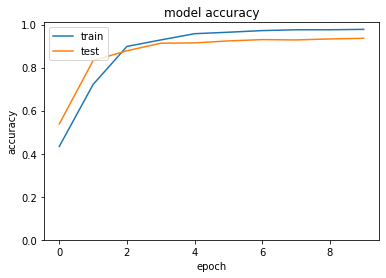

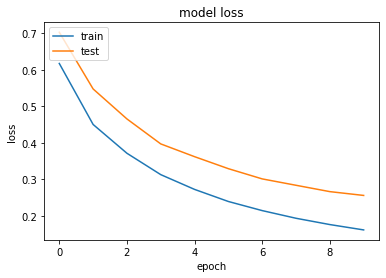

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.ylim([0,1.01])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [51]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = cnn2d_model.predict(X_val_padded)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print("Precision:", round(precision_score(y_val, y_pred , average="macro"),2))
print("Recall:", round(recall_score(y_val, y_pred , average="macro"),2))
print("F1 Score:", round(f1_score(y_val, y_pred , average="macro"),2))

Precision: 0.48
Recall: 0.5
F1 Score: 0.49


C:\Users\ketak\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Notes:
- The above way of implementaion is called sequential API, but most advanced deep learning models use functional API
- the code below uses Functional API of keras to implement same Fully Connected NN
- In the Keras Functional API, you have to define the input layer separately before the embedding layer. In the input, layer you have to simply pass the length of input vector. To specify that previous layer as input to the next layer, the previous layer is passed as a parameter inside the parenthesis, at the end of the next layer.

In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

deep_inputs = Input(shape=(length_long_sentence,))
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False)(deep_inputs) # line A
flatten = Flatten()(embedding)
hidden = Dense(1, activation='sigmoid')(flatten)
model = Model(inputs=deep_inputs, outputs=hidden)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 120, 300)          910800    
_________________________________________________________________
flatten_3 (Flatten)          (None, 36000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 36001     
Total params: 946,801
Trainable params: 36,001
Non-trainable params: 910,800
_________________________________________________________________


In [166]:
#In the model summary, you can see the input layer as a separate layer before the embedding layer. 
#tHe rest of the model remains the same.

#Finally, the process to fit and evaluate the model is same as the one used in Sequential API:

In [74]:
model.fit(X_train_padded, y_train, epochs=10,validation_data =(X_val_padded, y_val), verbose=1)

Epoch 1/10
103/103 [==============================] - 0s 3ms/step - loss: 0.2014 - acc: 0.9674 - val_loss: 0.2057 - val_acc: 0.9573
Epoch 2/10
103/103 [==============================] - 0s 2ms/step - loss: 0.1560 - acc: 0.9713 - val_loss: 0.1845 - val_acc: 0.9585
Epoch 3/10
103/103 [==============================] - 0s 2ms/step - loss: 0.1305 - acc: 0.9747 - val_loss: 0.1720 - val_acc: 0.9598
Epoch 4/10
103/103 [==============================] - 0s 2ms/step - loss: 0.1133 - acc: 0.9774 - val_loss: 0.1634 - val_acc: 0.9610
Epoch 5/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1005 - acc: 0.9790 - val_loss: 0.1565 - val_acc: 0.9610
Epoch 6/10
103/103 [==============================] - 0s 2ms/step - loss: 0.0905 - acc: 0.9808 - val_loss: 0.1515 - val_acc: 0.9610
Epoch 7/10
103/103 [==============================] - 0s 2ms/step - loss: 0.0823 - acc: 0.9814 - val_loss: 0.1476 - val_acc: 0.9610
Epoch 8/10
103/103 [==============================] - 0s 2ms/step - loss: 0.

## Simple LSTM

In [181]:
rnnmodel = Sequential()
rnnmodel.add(embedding_layer)
rnnmodel.add(LSTM(128))

rnnmodel.add(Dense(1, activation='sigmoid'))
rnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
rnnmodel.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 300)          910800    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 1,130,577
Trainable params: 219,777
Non-trainable params: 910,800
_________________________________________________________________


In [182]:
rnn_history = rnnmodel.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_split=0.2, class_weight=sklearn_weights)

Epoch 1/10
82/82 [==============================] - 5s 55ms/step - loss: 0.7005 - acc: 0.1945 - val_loss: 0.6935 - val_acc: 0.0259
Epoch 2/10
82/82 [==============================] - 4s 52ms/step - loss: 0.7003 - acc: 0.3349 - val_loss: 0.6959 - val_acc: 0.0259
Epoch 3/10
82/82 [==============================] - 5s 56ms/step - loss: 0.7003 - acc: 0.0305 - val_loss: 0.6978 - val_acc: 0.0259
Epoch 4/10
82/82 [==============================] - 4s 54ms/step - loss: 0.7005 - acc: 0.1533 - val_loss: 0.6955 - val_acc: 0.0259
Epoch 5/10
82/82 [==============================] - 4s 54ms/step - loss: 0.7003 - acc: 0.0305 - val_loss: 0.6981 - val_acc: 0.0259
Epoch 6/10
82/82 [==============================] - 4s 55ms/step - loss: 0.7003 - acc: 0.0305 - val_loss: 0.7013 - val_acc: 0.0259
Epoch 7/10
82/82 [==============================] - 4s 55ms/step - loss: 0.7002 - acc: 0.0305 - val_loss: 0.6968 - val_acc: 0.0259
Epoch 8/10
82/82 [==============================] - 5s 56ms/step - loss: 0.7003 - a

In [183]:
score = rnnmodel.evaluate(X_val_padded, y_val, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


Test Loss: 0.6987847089767456
Test Accuracy: 0.04024390131235123
